In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect, desc

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)
inspector = inspect(engine)

# Exploratory Precipitation Analysis

In [9]:
# Look at first 5 rows from measurement table
engine.execute('select * from measurement limit 5').fetchall()

[(1, 'USC00519397', '2010-01-01', 0.08, 65.0),
 (2, 'USC00519397', '2010-01-02', 0.0, 63.0),
 (3, 'USC00519397', '2010-01-03', 0.0, 74.0),
 (4, 'USC00519397', '2010-01-04', 0.0, 76.0),
 (5, 'USC00519397', '2010-01-06', None, 73.0)]

In [10]:
# inspect data types in measurement
measurement_columns = inspector.get_columns('measurement')
for column in measurement_columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [11]:
last_date = session.query(measurement.date).\
            order_by(measurement.date.desc()).\
            first()

last_date = last_date[0]
last_date = last_date.split('-')

first_date = dt.date(int(last_date[0]),
                         int(last_date[1]),
                         int(last_date[2])) - dt.timedelta(days=365)

measurement_results = session.query(measurement.date,
                                    func.max(measurement.prcp)).\
                                    filter(measurement.date >= first_date).\
                                    group_by(measurement.date).\
                                    order_by(measurement.date.asc()).all()

precip_df = pd.DataFrame(measurement_results, columns=['date', 'prcp'])
precip_df = precip_df.rename(columns={'prcp': 'Precipitation', 'date': 'Date'})
precip_df.set_index('Date', inplace=True)
precip_df = precip_df.dropna()
precip_df

,Precipitation
Date,
2016-08-23,1.79
2016-08-24,2.28
2016-08-25,0.21
2016-08-26,0.04
2016-08-27,0.18
...,...
2017-08-19,0.09
2017-08-20,0.01
2017-08-21,0.56


In [12]:
fmtd_last_date = dt.date(int(last_date[0]), int(last_date[1]), int(last_date[2]))
fmtd_last_date = fmtd_last_date.strftime('%m/%d/%Y')

fmtd_first_date = first_date.strftime('%m/%d/%Y')

print(fmtd_last_date)
print(fmtd_first_date)

08/23/2017
08/23/2016


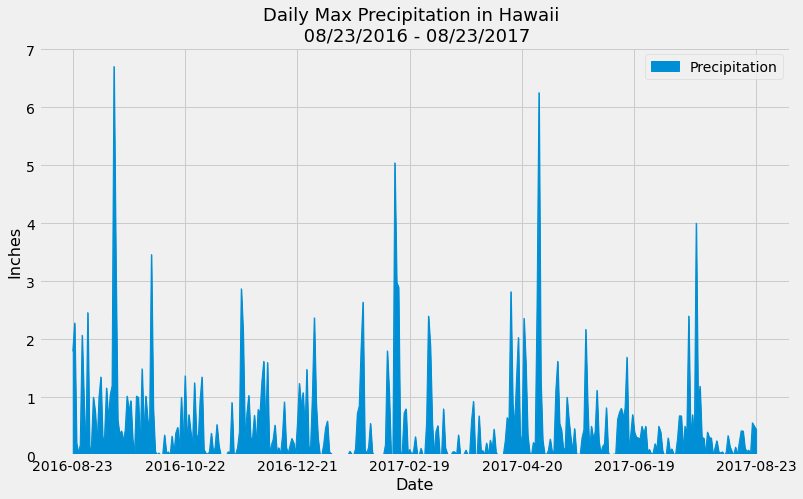

In [13]:
# Use Pandas Plotting with Matplotlib to plot the data
plt.rcParams['figure.figsize']=(12,7)
precip_df.plot.area(linewidth=1, xticks=(0, 60, 120, 180, 240, 300, 365))
plt.title(f'Daily Max Precipitation in Hawaii \n {fmtd_first_date} - {fmtd_last_date}', fontsize=18)
plt.xlabel('Date', fontsize=16)
plt.ylabel('Inches', fontsize=16)
plt.show()

In [14]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precip_df.describe()

,Precipitation
count,366.000000
mean,0.520765
std,0.830728
min,0.000000
25%,0.040000
50%,0.250000
75%,0.672500
max,6.700000


# Exploratory Station Analysis

In [15]:
# Design a query to calculate the total number stations in the dataset
station_count = session.query(func.count(measurement.id),
                              measurement.station).\
                              group_by(measurement.station).\
                              order_by(measurement.id.desc()).count()

print(f'There are {station_count} stations in the dataset.')

There are 9 stations in the dataset.


In [16]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
station_freq = session.query(func.count(measurement.tobs), measurement.station).\
                group_by(measurement.station).\
                order_by(desc(func.count(measurement.tobs))).all()

print('Most active stations, descending order:')
station_freq

Most active stations, descending order:


[(2772, 'USC00519281'),
 (2724, 'USC00519397'),
 (2709, 'USC00513117'),
 (2669, 'USC00519523'),
 (2612, 'USC00516128'),
 (2202, 'USC00514830'),
 (1979, 'USC00511918'),
 (1372, 'USC00517948'),
 (511, 'USC00518838')]

In [17]:
most_active_station = station_freq[0][1]

print(f'The most active station is station {most_active_station}.')

The most active station is station USC00519281.


In [18]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
# Highest
max_temp = session.query(func.max(measurement.tobs)).\
                        filter(measurement.station == most_active_station).first()
max_temp = max_temp[0]
print(f'{most_active_station} High Temp: {max_temp} degrees farenheit.')

# Lowest
min_temp = session.query(func.min(measurement.tobs)).\
                        filter(measurement.station == most_active_station).first()
min_temp = min_temp[0]
print(f'{most_active_station} Low Temp: {min_temp} degrees farenheit.')

# Average
avg_temp = session.query(func.avg(measurement.tobs)).\
                        filter(measurement.station == most_active_station).first()
avg_temp = avg_temp[0]
print(f'{most_active_station} Average Temp: {round(avg_temp, 2)} degrees farenheit.')

USC00519281 High Temp: 85.0 degrees farenheit.
USC00519281 Low Temp: 54.0 degrees farenheit.
USC00519281 Average Temp: 71.66 degrees farenheit.


In [19]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
active_last_date = session.query(measurement.date).\
                    order_by(measurement.date.desc()).\
                    filter(measurement.station == most_active_station).\
                    first()

active_last_date
active_last_date = active_last_date[0]
active_last_date = active_last_date.split('-')

active_first_date = dt.date(int(active_last_date[0]),
                         int(active_last_date[1]),
                         int(active_last_date[2])) - dt.timedelta(days=365)

active_measurement_results = session.query(measurement.date, measurement.tobs).\
                                        filter(measurement.date >= active_first_date).\
                                        filter(measurement.station == most_active_station)

tobs_df = pd.DataFrame(active_measurement_results, columns=['date', 'tobs'])
tobs_df = tobs_df.rename(columns={'date': 'Date', 'tobs': 'Temp. Observation'})
tobs_df.set_index('Date', inplace=True)
tobs_df = tobs_df.dropna()
tobs_df.head()

,Temp. Observation
Date,
2016-08-18,80.0
2016-08-19,79.0
2016-08-20,81.0
2016-08-21,79.0
2016-08-22,78.0


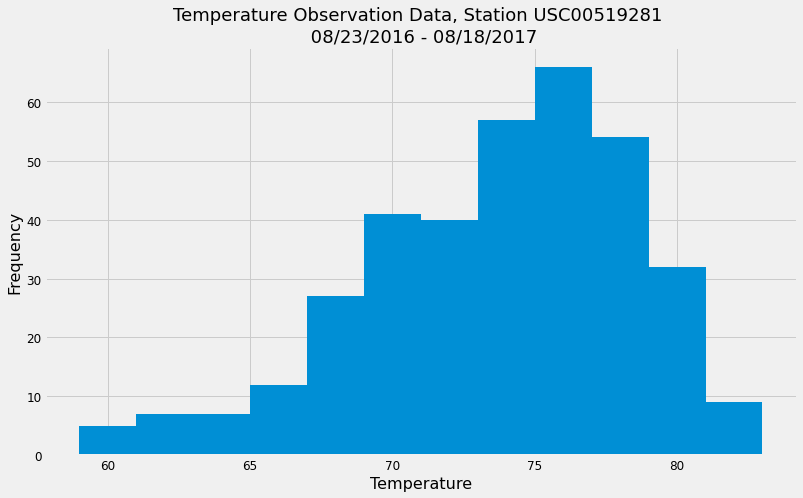

In [20]:
# Make histogram
tobs_x = tobs_df['Temp. Observation']

# Histogram labels
fmtd_last_active_date = dt.date(int(active_last_date[0]), int(active_last_date[1]), int(active_last_date[2]))
fmtd_last_active_date = fmtd_last_active_date.strftime('%m/%d/%Y')

fmtd_active_first_date = first_date.strftime('%m/%d/%Y')

plt.rcParams['figure.figsize']=(12,7)
plt.hist(tobs_x, bins=12)
plt.tick_params(axis='both', which='major', labelsize=12)
plt.xlabel('Temperature', size=16)
plt.ylabel('Frequency', size=16)
plt.title(f'Temperature Observation Data, Station {most_active_station} \n {fmtd_active_first_date} - {fmtd_last_active_date}',\
          size=18)
plt.show()

# Close session

In [21]:
# Close Session
session.close()